<a href="https://colab.research.google.com/github/ujeongmin/ESAA/blob/main/ESAA_HW_12_22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 06. 군집화 실습 - 고객 세그먼테이션

#### 고객 세그먼테이션의 정의와 기법
* 다양한 기준으로 고객을 분류하는 기법을 지칭, CRM이나 마케팅의 중요 기반 요소
* 고객의 어떤 요소를 기반으로 군집화할 것인가를 결정하는 것이 중요한데, 기본적인 고객 분석 요소인 RFM 기법을 이용
> Rencency : 가장 최근 상품 구입일에서 오늘까지의 기간  
> Frequency : 상품 구매 횟수  
> Monetary value : 총 구매 금액

#### 데이터 세트 로딩과 데이터 클렌징

In [17]:
import pandas as pd
import datetime
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from google.colab import drive
drive.mount('/content/gdrive')
retail_df = pd.read_excel('/content/gdrive/MyDrive/ESAA/data/Online_Retail.xlsx')
retail_df.head(3)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom


In [6]:
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


* CustomerID의 Null 값이 너무 많고 다른 칼럼도 오류 데이터가 존재, 따라서 먼저 사전 정제 작업이 필요함
* 불린 인덱싱을 적용해 필터링

In [18]:
retail_df = retail_df[retail_df['Quantity']>0]
retail_df = retail_df[retail_df['UnitPrice']>0]
retail_df = retail_df[retail_df['CustomerID'].notnull()]
print(retail_df.shape)
retail_df.isnull().sum()

(397884, 8)


InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

* 전체 데이터가 줄어듬
* Country 칼럼은 영국이 대다수를 차지하므로 다른 국가의 데이터는 모두 제외, 데이터 사전 정제 마침

In [8]:
retail_df['Country'].value_counts()[:5]

United Kingdom    354321
Germany             9040
France              8341
EIRE                7236
Spain               2484
Name: Country, dtype: int64

In [19]:
retail_df = retail_df[retail_df['Country']=='United Kingdom']
print(retail_df.shape)

(354321, 8)


#### RFM 기반 데이터 가공
* 사전 정제된 데이터 기반으로 고객 세그먼테이션 군집화를 RFM 기반으로 수행
* 이를 위해 'UnitPrice'와 'Quantity'를 곱해서 주문 금액 데이터 만듬
* CustomerNo도 더 편리한 식별성을 위해 float형에서 int형으로 변경

In [20]:
retail_df['sale_amount'] = retail_df['Quantity'] * retail_df['UnitPrice']
retail_df['CustomerID'] = retail_df['CustomerID'].astype(int)

* 해당 온라인 판매 데이터 세트는 주문 횟수와 주문 금액이 압도적으로 특정 고객에게 많은 특성을 가지고 있음

In [11]:
print(retail_df['CustomerID'].value_counts().head(5))
print(retail_df.groupby('CustomerID')['sale_amount'].sum().sort_values(ascending=False)[:5])

17841    7847
14096    5111
12748    4595
14606    2700
15311    2379
Name: CustomerID, dtype: int64
CustomerID
18102    259657.30
17450    194550.79
16446    168472.50
17511     91062.38
16029     81024.84
Name: sale_amount, dtype: float64


* 위처럼 몇몇 특정 고객이 많은 주문 건수와 주문 금액을 가지고 있음
* 주어진 데이터 세트는 주문번호+상품코드 레벨의 식별자로 되어있음
> InvoiceNo + StockCode로 Group by를 수행하면 거의 1에 가깝게 유일한 식별자 레벨이 됨을 알 수 있음

In [21]:
retail_df.groupby(['InvoiceNo','StockCode'])['InvoiceNo'].count().mean()

1.028702077315023

* 그런데 지금 수행하려는 RFM 기반의 고객 세그먼테이션은 고객 레벨로 주문 기간, 주문 횟수, 주문 금액 데이터를 기반으로 하여 세그먼테이션을 수행하는 것임
* 이를 위해서는 주문번호 기준의 데이터를 개별 고객 기준의 데이터로 Group by 해야 함

In [22]:
# DataFrame의 groupby()의 multiple 연산을 위해 agg() 이용
# Recency는 InvoiceDate 칼럼의 max()에서 데이터 가공
# Frequency는 InvoiceNo 칼럼의 count(), Monetary value는 sale_amount 칼럼의 sum()

aggregations = {
    'InvoiceDate' : 'max',
    'InvoiceNo' : 'count',
    'sale_amount' : 'sum'
}
cust_df = retail_df.groupby('CustomerID').agg(aggregations)
# groupby된 결과 칼럼 값을 Recency, Frequency, Monetary로 변경
cust_df = cust_df.rename(columns = {'InvoiceDate':'Recency',
                                    'InvoiceNo':'Frequency',
                                    'sale_amount':'Monetary'})
cust_df = cust_df.reset_index()
cust_df.head(3)

,CustomerID,Recency,Frequency,Monetary
0,12346,2011-01-18 10:01:00,1,77183.60
1,12747,2011-12-07 14:34:00,103,4196.01
2,12748,2011-12-09 12:20:00,4595,33719.73


* Recency 칼럼은 개별 고객당 가장 최근의 주문인데, 아직 데이터 가공이 추가로 필요함
* 오늘 날짜를 기준으로 가장 최근 주문 일자를 뺀 날짜인데, 주의할 점은 오늘 날짜를 현재 날짜로 해서는 안됨
* 데이터가 2010-12-1~2011-12-9의 데이터이므로 현재 날짜는 2011-12-9에서 하루 더한 12-10으로 간주함
* 현재 날짜에서 가장 최근의 주문 일자를 뺀 데이터에서 일자 데이터(days)만 추출해 생성

In [23]:
import datetime as dt

cust_df['Recency'] = dt.datetime(2011, 12, 10) - cust_df['Recency']
cust_df['Recency'] = cust_df['Recency'].apply(lambda x: x.days+1)
print('cust_df 로우와 칼럼 건수는 ', cust_df.shape)
cust_df.head(3)

cust_df 로우와 칼럼 건수는  (3920, 4)


,CustomerID,Recency,Frequency,Monetary
0,12346,326,1,77183.60
1,12747,3,103,4196.01
2,12748,1,4595,33719.73


* 이제 고객별로 RFM 분석에 필요한 세 칼럼 모두 생성함

#### RFM 기반 고객 세그먼테이션
* 먼저 데이터 세트의 칼럼별 히스토그램 확인하고 왜곡된 데이터 분포도에서 군집화를 수행할 때 어떤 현상이 발생하는지 알아봄

(array([3.887e+03, 1.900e+01, 9.000e+00, 2.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00]),
 array([3.75000000e+00, 2.59691050e+04, 5.19344600e+04, 7.78998150e+04,
        1.03865170e+05, 1.29830525e+05, 1.55795880e+05, 1.81761235e+05,
        2.07726590e+05, 2.33691945e+05, 2.59657300e+05]),
 <BarContainer object of 10 artists>)

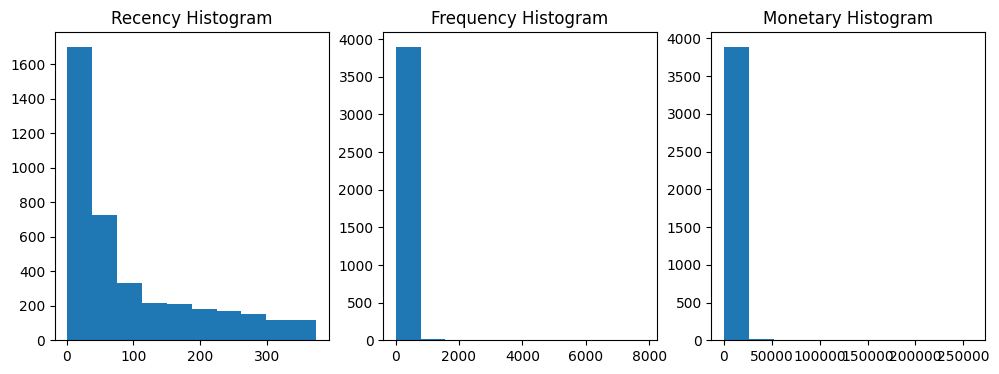

In [24]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(12,4), nrows=1, ncols=3)
ax1.set_title('Recency Histogram')
ax1.hist(cust_df['Recency'])

ax2.set_title('Frequency Histogram')
ax2.hist(cust_df['Frequency'])

ax3.set_title('Monetary Histogram')
ax3.hist(cust_df['Monetary'])

* 세 칼럼 모두 왜곡된 데이터 값 분포도를 가지고 있으며 특히 2,3번째가 매우 심함
* 각 칼럼의 데이터 값 백분위로 대략적으로 어떻게 값이 분포돼 있는지 확인

In [25]:
cust_df[['Recency', 'Frequency', 'Monetary']].describe()

,Recency,Frequency,Monetary
count,3920.000000,3920.000000,3920.000000
mean,92.742092,90.388010,1864.385601
std,99.533485,217.808385,7482.817477
min,1.000000,1.000000,3.750000
25%,18.000000,17.000000,300.280000
50%,51.000000,41.000000,652.280000
75%,143.000000,99.250000,1576.585000
max,374.000000,7847.000000,259657.300000


* max값을 포함한 상위 몇 개의 큰 값으로 인해 발생한 현상
* 왜곡 정도가 매우 높은 데이터 세트에 K-평균 군집을 적용하면 중심의 개수를 증가시키더라도 변별력이 떨어지는 군집화가 수행됨
* StandardScaler로 재조정한 뒤 K-평균 수행해봄

In [28]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

X_features = cust_df[['Recency', 'Frequency', 'Monetary']].values
X_features_scaled = StandardScaler().fit_transform(X_features)

kmeans = KMeans(n_clusters=3, random_state=0)
labels = kmeans.fit_predict(X_features_scaled)
cust_df['cluster_label'] = labels
print('실루엣 스코어는 : {0:.3f}'.format(silhouette_score(X_features_scaled, labels)))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


실루엣 스코어는 : 0.592


* 군집을 3개로 구성할 경우 전체 군집의 평균 실루엣 계수인 실루엣 스코어는 0.592로 안정적인 수치가 나옴
* 각 군집별 실루엣 계수 시각화 해봄

In [ ]:
visualize_silhouette([2,3,4,5], X_features_scaled)
visualize_kmeans_plot_multi([2,3,4,5], X_features_scaled)

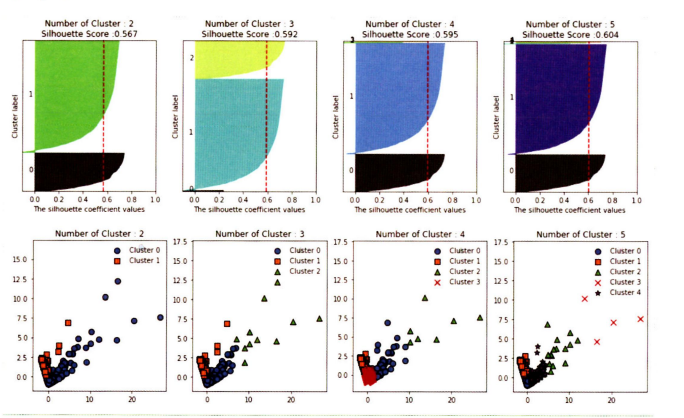

* 2개면 0번,1번 군집이 너무 개괄적으로 군집화됨
* 3개 이상이면 데이터 개수가 너무 작은 군집이 만들어져 실루엣 계수 역시 매우 작음
* 이처럼 지나치게 왜곡된 데이터 세트는 K-평균과 같은 거리 기반 군집화 알고리즘에서 지나치게 일반적인 군집화 결과를 도출하게 됨
* 이번에는 왜곡 정도를 낮추기 위해 로그 변환한 후 K-평균 알고리즘을 적용하고 결과를 비교해 봄

In [29]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

# Recency, Frequency, Monetary 칼럼에 np.log1p()로 Log Transformation
cust_df['Recency_log'] = np.log1p(cust_df['Recency'])
cust_df['Frequency_log'] = np.log1p(cust_df['Frequency'])
cust_df['Monetary_log'] = np.log1p(cust_df['Monetary'])

# Log Transformation 데이터에 StandardScaler 적용
X_features = cust_df[['Recency_log', 'Frequency_log', 'Monetary_log']].values
X_features_scaled = StandardScaler().fit_transform(X_features)

kmeans = KMeans(n_clusters=3, random_state=0)
labels = kmeans.fit_predict(X_features_scaled)
cust_df['cluster_label'] = labels
print('실루엣 스코어는 : {0:.3f}'.format(silhouette_score(X_features_scaled, labels)))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


실루엣 스코어는 : 0.303


* 실루엣 스코어는 로그 변환하기 전보다 떨어지지만 개별 군집을 살펴봐야함
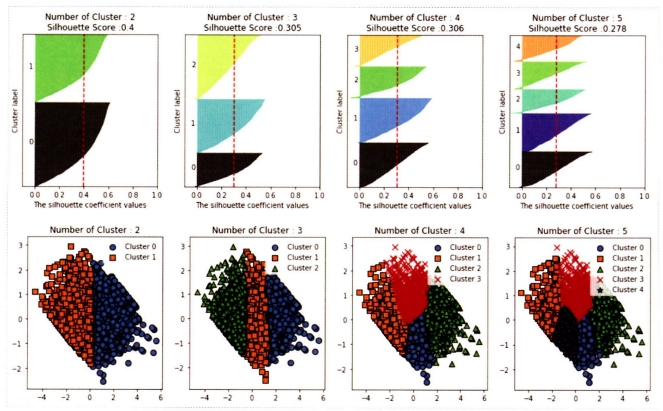

* 더 균일하게 균집화가 구성됐음을 알 수 있음
* 이처럼 왜곡된 데이터 세트에 대해서는 로그 변환으로 데이터를 일차 변환한 후에 군집화를 수행하면 더 나은 결과를 도출할 수 있음